In [3]:
import os
from langchain_community.chat_models.ollama import ChatOllama

llm = ChatOllama(model="llama3", temperature=0)

In [2]:
response = llm.invoke("What is the capital of Nepal")
print(type(response))
print(response)

<class 'langchain_core.messages.ai.AIMessage'>
content='{}' response_metadata={'model': 'llama3', 'created_at': '2024-06-15T13:24:24.320391Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 181570791, 'load_duration': 1240041, 'prompt_eval_count': 11, 'prompt_eval_duration': 160378000, 'eval_count': 2, 'eval_duration': 17647000} id='run-101433fd-7256-4547-994b-a6a485597cb8-0'


In [10]:
from langchain_core.output_parsers import StrOutputParser

test_chain = llm | StrOutputParser()

print(test_chain.invoke("Tell me 5 small jokes "))

Here are five small jokes:

1. Why don't eggs tell jokes? They'd crack each other up!
2. What do you call a fake noodle? An impasta!
3. Why did the scarecrow win an award? Because he was outstanding in his field!
4. What do you call a can opener that doesn't work? A can't opener!
5. Why did the bicycle fall over? Because it was two-tired!

I hope these little jokes bring a smile to your face!


#### Testing with foramt as JSON

In [4]:
# from langchain_community.chat_models import ChatOllama
# from langchain_core.output_parsers import JsonOutputParser
# from langchain_core.prompts import PromptTemplate

# # LLM
# llm = ChatOllama(model='llama3', format="json", temperature=0)

# prompt = PromptTemplate(
#     template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant. Answer the user
#     question honestly. Format of the answer should be in json with 1 key as 'answer'.
#     User will provide a statement, reply to the user honestly.
#     Do not include any pre-amble before the answer
#      <|eot_id|><|start_header_id|>user<|end_header_id|>
#     Here is the user statement: {statement} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
#     """,
#     input_variables=["statement"],
# )

# test_llm = prompt | llm | JsonOutputParser()
# question = "Tell me a joke about batman"
# print(test_llm.invoke({"statement": question}))

## Part 1. Basic Chatbot

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [7]:
dir(graph_builder)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_edges',
 'add_conditional_edges',
 'add_edge',
 'add_node',
 'branches',
 'channels',
 'compile',
 'compiled',
 'config_schema',
 'edges',
 'managed',
 'nodes',
 'schema',
 'set_conditional_entry_point',
 'set_entry_point',
 'set_finish_point',
 'support_multiple_edges',
 'validate',
 'waiting_edges']

In [8]:
# Next, add a "chatbot" node. Nodes represent units of work. 
# They are typically regular python functions.

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [9]:
# Next, add an entry point. This tells our graph where to start its work each time we run it.

graph_builder.set_entry_point("chatbot")

In [10]:
# Set a finish point. This instructs the graph "any time this node is run, you can exit."

graph_builder.set_finish_point("chatbot")

In [11]:
# Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

graph = graph_builder.compile()

In [12]:
dir(graph)

['Config',
 'InputType',
 'OutputType',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__config__',
 '__custom_root_type__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__exclude_fields__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__include_fields__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__json_encoder__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__post_root_validators__',
 '__pre_root_validators__',
 '__pretty__',
 '__private_attributes__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__repr_args__',
 '__repr_name__',
 '__repr_str__',
 '__rich_repr__',
 '__ror__',
 '__schema_cache__',
 '__setattr__',
 '__setstate__',
 '__signature__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__try_update_forward_ref

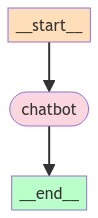

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [10]:
# Now let's run the chatbot!
# Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        # print(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Nice to meet you, Vinay! I'm here to help with any questions or topics you'd like to discuss. What's on your mind?
Assistant: Yes, I'm a large language model, I don't have personal memories like humans do, but I can recall our previous conversations. Unfortunately, this is the start of our interaction, so I haven't had the chance to learn your name yet.
Goodbye!


## Part 2. Enhancing the Chatbot with Tools
### i) With Raw Implementation

In [3]:
from langchain_core.tools import tool
# from langgraph.prebuilt import ToolNode
# from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate

os.environ["TAVILY_API_KEY"] = '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'

In [4]:
# @tool
# def websearch(input : str) -> str:
#     """Runs web search"""
#     tool = TavilySearchResults(max_results=2)
#     docs = tool.invoke({"query":input})
#     return docs


In [5]:
# response = websearch.invoke("What is the weather in New Delhi now?")
# response

In [6]:
# from langchain_core.tools import tool

# @tool
# def magic_function(x:float, y:float) -> float:
#     "Given two float numbers x and y in arguments, it returns the multiplication of x and y"
#     return (x*y)

# magic_function.invoke({"x":2.3, "y":3})

In [7]:
# def handle_tool_error(state) -> dict:
#     error = state.get("error")
#     tool_calls = state["messages"][-1].tool_calls
#     return {
#         "messages": [
#             ToolMessage(
#                 content=f"Error: {repr(error)}\n please fix your mistakes.",
#                 tool_call_id=tc["id"],
#             )
#             for tc in tool_calls
#         ]
#     }


# def create_tool_node_with_fallback(tools: list) -> dict:
#     return ToolNode(tools).with_fallbacks(
#         [RunnableLambda(handle_tool_error)], exception_key="error"
#     )



# tools = [magic_function, websearch]

In [2]:
from typing import List, Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage


class State(TypedDict):
    messages : Annotated[List, add_messages]
    question: str
    datasource : str
    websearch_docs : List[str]
    magic_answer : float
    answer : str

graph_builder = StateGraph(State)

In [9]:
def decisioner(state: State):

    print("----"*20, 'Decisioner', "----"*20)
    print(state)
    print("----"*50)

    question = state["question"]
    messages = state["messages"]

    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful chat assistant who is good in conversation.
            Apart from your own knowledge base, you also have access to follow two tools: 
            1) websearch - Runs web search
            2) magic_function - It requires two float numbers x and y in arguments
            Respond to the user question honestly. Generate the answer if you can answer the user question based on your knowledge, 
            otherwise take help from the above tools to respond.
            Format of your response should be in json with 2 keys - 'datasource' and 'answer'
            If you are sure about the answer, 'datasource' should be '__end__' and final answer should be provided in 'answer' key
            If you need to use the tool to respond to user question, 'datasource' value should be either 'websearch' or 'magic_function'.
            Value of 'answer' key should be blank string for 'websearch',  and Value of 'answer' key should be list of float numbers for 'magic_function'.
            For example, user question - What is magic_function(2,3)?, value of answer key - [2,3]
            Do not include any pre-amble before your response

            Additionally, here is the chat history between user and you (assistant) till now for your reference:

            {chat_history}

            <|eot_id|>
            <|start_header_id|>user<|end_header_id|>
            Question: {question}

            Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>
            """,
        input_variables=["question", "chat_history"],
    )

    decision_chain = prompt | llm | JsonOutputParser()

    result = {}

    i = 1
    while True:
        print(i)
        response = decision_chain.invoke({'question':question, "chat_history":messages})

        datasource = response.get('datasource', '')

        if datasource in ['websearch', 'magic_function']:
            result = {**response,
                      'messages':[HumanMessage(content=question)]}
            break
        elif datasource == '__end__':
            result = {**response,
                      'messages':[HumanMessage(content=question),
                                  AIMessage(response['answer'])]}
            break

        i+=1
        if i>=5:
            raise Exception("Over reached")
    
    return result

In [10]:
# prompt = PromptTemplate(
#     template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant.
#     You have two tools at your disposal : 
#     1) websearch - Runs web search
#     2) magic_function - It requires two float numbers x and y in arguments
#     Answer the user question honestly. Generate the answer if you know the answer, otherwise delegate the task to the tools.
#     Format of your response should be in json with 2 keys - 'datasource' and 'answer'
#     If you are sure about the answer, 'datasource' should be '__end__' and final answer should be provided in 'answer' key
#     If you need to use the tool to respond to user question, 'datasource' value should be either 'websearch' or 'magic_function'.
#     Value of 'answer' key should be blank string for 'websearch',  and Value of 'answer' key should be list of float numbers for 'magic_function'.
#     For example, user question - What is magic_function(2,3)?, value of answer key - [2,3]
#     Do not include any pre-amble before your response
#     <|eot_id|><|start_header_id|>user<|end_header_id|>
#     Question: {question}

#     Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>
#     """,
#     input_variables=["question"],
#     )

# decision_chain = prompt | llm | JsonOutputParser()


# # decision_chain.invoke({"question":"What is Capital of Nepal"})
# # decision_chain.invoke({"question":"What is weather in New Delhi right now"})
# decision_chain.invoke({"question":"What is magic_function(4,5)"})

In [11]:
from langchain_core.documents import Document

web_search_tool = TavilySearchResults(max_results=2)

def websearch(state: State):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Web results to websearch_docs
    """


    print("----"*20, 'Websearch', "----"*20)
    print(state)
    print("----"*50)

    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    return {"websearch_docs": [web_results], "question": question}
    

In [12]:
@tool
def magic_function_tool(x:float, y:float) -> float:
    "Given two float numbers x and y in arguments, it returns the multiplication of x and y"
    return (x*y)

def magic_function(state: State):
    """
    Given two float numbers x and y in arguments, it returns the multiplication of x and y


    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Magic function result
    """


    print("----"*20, 'Magic Function', "----"*20)
    print(state)
    print("----"*50)

    args = state["answer"]

    if len(args)!=2:
        raise Exception(f"Magic function received incorrect arguments: {args}")

    result = magic_function_tool.invoke({'x':args[0], 'y':args[1]})

    return {"magic_answer": result}

In [13]:

def generate(state: State):
    """
    Generate the final answer if question is routed through Web search or Magic function

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Returns the final anwer in key 'answer'
    """
    
    print("----"*20, 'Final Generate', "----"*20)
    print(state)
    print("----"*50)

    question = state["question"]
    if state['datasource'] == 'websearch':
        context = state['websearch_docs']
    else:
        context = f"The magic function result is {state['magic_answer']}"

    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
            Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
            Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
            Question: {question} 
            Context: {context} 
            Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>
            """,
        input_variables=["question", "context"],
    )

    chain = prompt | llm | StrOutputParser()
    generation = chain.invoke({'question':question, 'context':context})

    result = {'messages':[AIMessage(generation)], "answer": generation}
    

    return result

In [14]:
### Conditional edge

def route_question(state: State):
    """
    Route question to web search, Magic function or End node.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("----"*20, f'Routing Question', "----"*20)
    print(state)
    print("----"*50)


    datasource = state['datasource']


    return datasource

In [15]:
# Build Graph

## Add Nodes
graph_builder.add_node("decisioner", decisioner)
graph_builder.add_node("websearch", websearch)
graph_builder.add_node("magic_function", magic_function)
graph_builder.add_node("generate", generate)

In [16]:
## Add Edges
graph_builder.add_conditional_edges(
    "decisioner",
    route_question,
    {
        "websearch": "websearch",
        "magic_function": "magic_function",
        "__end__": "__end__"
    },
)

graph_builder.add_edge("websearch", "generate")
graph_builder.add_edge("magic_function", "generate")
graph_builder.add_edge("generate", "__end__")


graph_builder.set_entry_point("decisioner")


In [17]:

from langgraph.checkpoint.sqlite import SqliteSaver

# Persist chat with thread id
memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(checkpointer=memory)

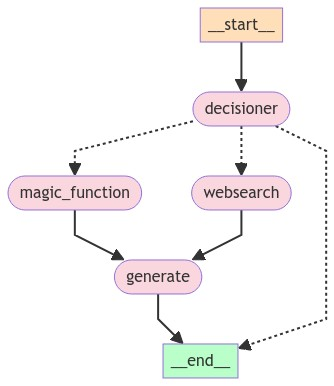

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [19]:
from pprint import pprint

config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "Hi, my name is Vinay?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': None, 'question': 'Hi, my name is Vinay?', 'datasource': None, 'websearch_docs': None, 'magic_answer': None, 'answer': None}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1
-------------------------------------------------------------------------------- Routing Question --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?")], 'question': 'Hi, my name is Vinay?', 'datasource': '__end__', 'answer': "Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?"}


In [20]:
config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "Remember my Name?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?")], 'question': 'Remember my Name?', 'datasource': '__end__', 'websearch_docs': None, 'magic_answer': None, 'answer': "Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?"}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1
-------------------------------------------------------------------------------- Routing Question --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?', id='a2385c48-638d-4fba-a4be-abc669ec

In [21]:
config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "What was my previous question?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?', id='a2385c48-638d-4fba-a4be-abc669ecfad3'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?", id='1cd22ac0-f4e1-4f29-86f9-bbd242152a4e'), HumanMessage(content='Remember my Name?', id='10e96675-5be1-423a-89b3-4967bd498539'), AIMessage(content='Vinay', id='3ff10321-a7e7-45fe-b07c-82db8c3fcd0e')], 'question': 'What was my previous question?', 'datasource': '__end__', 'websearch_docs': None, 'magic_answer': None, 'answer': 'Vinay'}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1
-------------------------------------------------------------------------------- Routin

In [22]:
config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "What is magic_function(5,7) ?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?', id='a2385c48-638d-4fba-a4be-abc669ecfad3'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?", id='1cd22ac0-f4e1-4f29-86f9-bbd242152a4e'), HumanMessage(content='Remember my Name?', id='10e96675-5be1-423a-89b3-4967bd498539'), AIMessage(content='Vinay', id='3ff10321-a7e7-45fe-b07c-82db8c3fcd0e'), HumanMessage(content='What was my previous question?', id='ed48cd63-ba29-410d-9d1a-c254f726fa87'), AIMessage(content='Remember my Name?', id='bc394656-795e-4a0c-ba1d-8e2901ad20bf')], 'question': 'What is magic_function(5,7) ?', 'datasource': '__end__', 'websearch_docs': None, 'magic_answer': None, 'answer': 'Remember my Name?'}
-------------------------------------------------------------------------------------------------

In [23]:
config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "What is magic_function(5,7) ?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?', id='a2385c48-638d-4fba-a4be-abc669ecfad3'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?", id='1cd22ac0-f4e1-4f29-86f9-bbd242152a4e'), HumanMessage(content='Remember my Name?', id='10e96675-5be1-423a-89b3-4967bd498539'), AIMessage(content='Vinay', id='3ff10321-a7e7-45fe-b07c-82db8c3fcd0e'), HumanMessage(content='What was my previous question?', id='ed48cd63-ba29-410d-9d1a-c254f726fa87'), AIMessage(content='Remember my Name?', id='bc394656-795e-4a0c-ba1d-8e2901ad20bf'), HumanMessage(content='What is magic_function(5,7) ?', id='0ebfe345-8156-4233-ac57-ee1eda732f41'), AIMessage(content="I don't know.", id='8b8cf540-a64d-48e5-a8a2-2b3d8ede47dc')], 'question': 'What is magic_function(5,7) ?', 'datasource': 'magic_f

In [24]:
config = {"configurable": {"thread_id": "sess5"}}

inputs = {"question": "What is the weather in New Delhi right now?"}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        # pprint(f"Finished running: {key}:")
        pass

print('\n'*2)
print(value["answer"])

-------------------------------------------------------------------------------- Decisioner --------------------------------------------------------------------------------
{'messages': [HumanMessage(content='Hi, my name is Vinay?', id='a2385c48-638d-4fba-a4be-abc669ecfad3'), AIMessage(content="Nice to meet you, Vinay! I'm happy to chat with you. What's on your mind?", id='1cd22ac0-f4e1-4f29-86f9-bbd242152a4e'), HumanMessage(content='Remember my Name?', id='10e96675-5be1-423a-89b3-4967bd498539'), AIMessage(content='Vinay', id='3ff10321-a7e7-45fe-b07c-82db8c3fcd0e'), HumanMessage(content='What was my previous question?', id='ed48cd63-ba29-410d-9d1a-c254f726fa87'), AIMessage(content='Remember my Name?', id='bc394656-795e-4a0c-ba1d-8e2901ad20bf'), HumanMessage(content='What is magic_function(5,7) ?', id='0ebfe345-8156-4233-ac57-ee1eda732f41'), AIMessage(content="I don't know.", id='8b8cf540-a64d-48e5-a8a2-2b3d8ede47dc'), HumanMessage(content='What is magic_function(5,7) ?', id='a3e40390-c